Feb 19 update (Jean): 
- implemented: verified PCA decomposition and also did PCA on the other grid id (heading 2)
- implemented: train/test split
- implemented: using vectors from 333519 to apply to 333346 and vice versa

priority
- plot PCA charts
- include explained variance of the two PCAs 
- interpretation of the PCA vectors
question: what does the first 2 dimensions mean? or first 10 to 20?
contain all 3000 boxes with some coefficients, size of a specific coefficient
we can look at the eigenvector of the largest pca value
pc1 describes outliers, maybe it's "boxes completely outside of the centre region"? bcos the cross evaluation works so well!
- cluster on PCA data to put in precision, recall etc.



future
- check the ID for the 3 points with the highest PC1 values
- use bootstrap to enhance the data to see how this impacts PCA
- draw out all the plots for same grid ID and cross grid ID tests

# 1. Preprocessing and binning

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle as pk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

SAVE_DIR = "pca-feb-20"

In [2]:
# loading data and choosing grid

data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')

# choose between 333519, 333346

grid_id = 333346
# grid_id = 333519

scale = StandardScaler()


In [3]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

In [4]:
cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

In [5]:
# Labelling points with ground truth
if grid_id == 333346:
    cb = cb_333346
elif grid_id == 333519:
    cb = cb_333519

In [6]:
# uncomment to visualize heatmap data
# data_heatmap

In [7]:
# expand table so that each row corresponds to 1 click:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [8]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


#aggregated_clicks['clicks_sum'].astype('int64');

In [9]:
# More binning: add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
# data_binned = data_binned[data_binned['grid_id'] == 333519]

In [10]:
# data_binned['grid_id'].unique()

In [11]:
data_binned = data_binned[data_binned['grid_id'] == grid_id]

In [12]:
# create a wide-format DataFrame such that each row corresponds to one heatmap
pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)

# Reset index to make 'domain' and 'grid_id' regular columns
pivot_df.reset_index(inplace=True)

# Rename columns to match the desired format
pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

# Uncomment to view pivot_df
#print(pivot_df)

In [13]:
input = pivot_df.copy()


In [14]:
# Version 1 of normalizing
# Normalizing such that the total number of clicks in one heatmap sums to one. We do not standardize because standardization assumes the clicks follow a normal distribution, which is not the case
normalized_input = input.copy()

normalized_input.iloc[:,2:] = (input.iloc[:,2:].transpose()/input.iloc[:,2:].sum(axis=1)).transpose()

normalized_input.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_40,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49
0,ID_1,333346,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
1,ID_10,333346,0.023926,0.01595,0.005317,0.000443,0.000443,0.000000,0.000443,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
2,ID_1002,333346,0.000000,0.00000,0.001733,0.000000,0.000000,0.001733,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
3,ID_1005,333346,0.000000,0.00000,0.000000,0.000000,0.001278,0.000000,0.000320,0.0,...,0.00032,0.0,0.0,0.0,0.0,0.00032,0.0,0.0,0.000639,0.000000
4,ID_1010,333346,0.000000,0.00000,0.000000,0.000000,0.000000,0.003236,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.003236


In [15]:
# Version 2 of normalizing, same result as version 1
normalized_input_2 = input.copy()
normalized_input_2.iloc[:,2:] = normalized_input_2.iloc[:,2:].div(normalized_input_2.iloc[:,2:].sum(axis=1), axis=0)
normalized_input_2.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_40,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49
0,ID_1,333346,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
1,ID_10,333346,0.023926,0.01595,0.005317,0.000443,0.000443,0.000000,0.000443,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
2,ID_1002,333346,0.000000,0.00000,0.001733,0.000000,0.000000,0.001733,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000
3,ID_1005,333346,0.000000,0.00000,0.000000,0.000000,0.001278,0.000000,0.000320,0.0,...,0.00032,0.0,0.0,0.0,0.0,0.00032,0.0,0.0,0.000639,0.000000
4,ID_1010,333346,0.000000,0.00000,0.000000,0.000000,0.000000,0.003236,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.003236


In [16]:
normalized_input['label'] = 0
normalized_input.loc[normalized_input.domain.isin(cb),'label'] = 1
# normalized_input.head(10)

In [17]:
X = normalized_input.iloc[:,2:-1]
y = normalized_input.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. PCA base code

## 2a. PCA to n = 200

In [18]:
# Plot explained variance ratio
features = normalized_input.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index

# Select the number of components (in this case, reduce to 2 dimensions)
n_components = 200

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
pca_result = pipeline.fit_transform(normalized_input[features])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the first column (index) from pca_input to pca_df
pca_df['domain'] = normalized_input['domain']

# Display the resulting DataFrame
#print(pca_df)

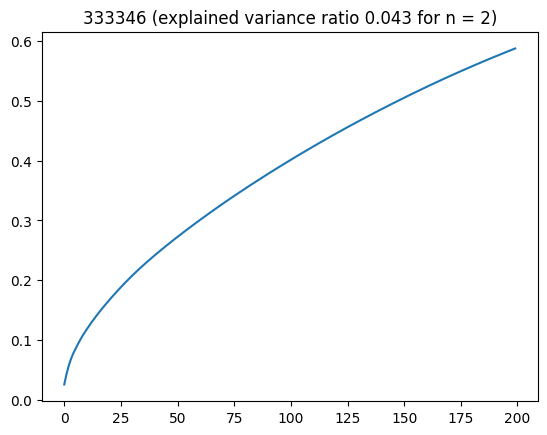

In [19]:
# Plot the cumulative explained variance ratio by the first k eigenvectors
pca_object = pipeline.named_steps['pca']
pca_exp_var = pca_object.explained_variance_ratio_
plt.plot(np.cumsum(pca_exp_var))
plt.title(f"{grid_id} (explained variance ratio {round(sum(pca_exp_var[:2]), 3)} for n = 2)")

# print(sum(pca_exp_var[:2]))

plt.savefig(f"{SAVE_DIR}/{grid_id}_explained-variance.jpg")

## 2b. PCA to n = 2

In [20]:
# PCA to n = 2

features = normalized_input.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index

# Select the number of components (in this case, reduce to 2 dimensions)
n_components = 2

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
pca_result = pipeline.fit_transform(normalized_input[features])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the first column (index) from pca_input to pca_df
pca_df['domain'] = normalized_input['domain']

In [21]:
print(grid_id)

333346


In [22]:
pca_df

,PC1,PC2,domain
0,-2.201697,1.082825,ID_1
1,8.817207,-8.646301,ID_10
2,1.826286,-4.574344,ID_1002
3,-4.007790,1.518168,ID_1005
4,-1.828073,-0.004985,ID_1010
...,...,...,...
856,-4.262584,0.820130,ID_978
857,0.675746,-1.081756,ID_989
858,-2.246456,2.059049,ID_993
859,-1.471568,-0.553920,ID_996


In [23]:
pca_df['label'] = 0

pca_df.loc[pca_df.domain.isin(cb),'label'] = 1
pca_df['label'].sum()

113

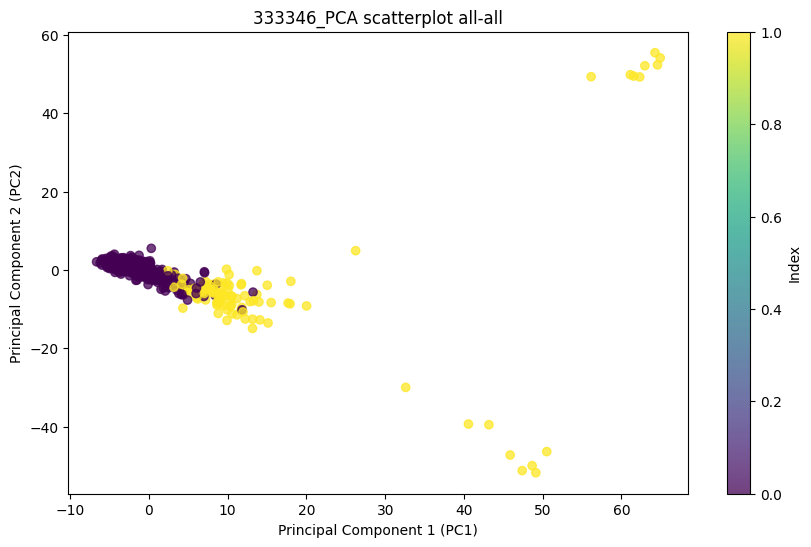

In [24]:
# Plotting pca_df with ground truth labels
pca_df1 = pca_df
plt.figure(figsize=(10, 6))
plt.scatter(pca_df1['PC1'], pca_df1['PC2'], c=pca_df1['label'], cmap='viridis', alpha=0.75)
plt.title(f'{grid_id}_PCA scatterplot all-all')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f"{SAVE_DIR}/{grid_id}_PCA-all-all.jpg")

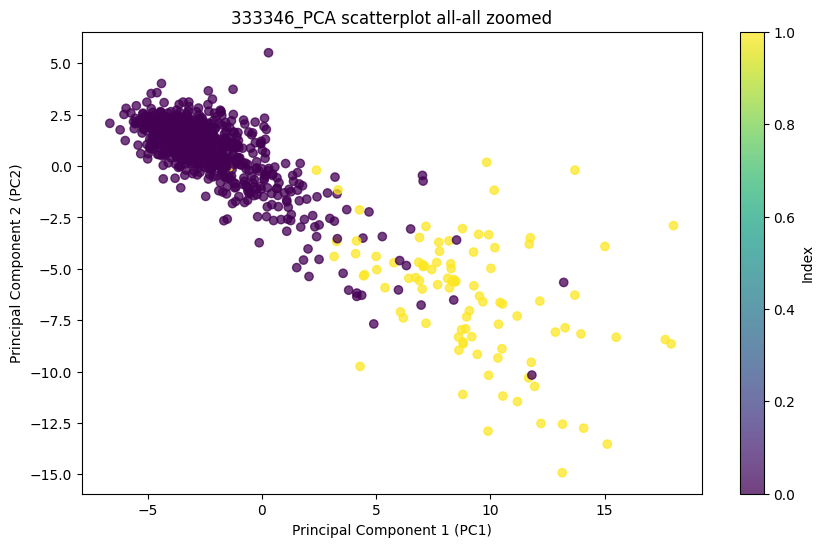

In [25]:
# Zoomed plot of pca_df with ground truth labels

pca_df1 = pca_df[pca_df.PC1<20]
plt.figure(figsize=(10, 6))
plt.scatter(pca_df1['PC1'], pca_df1['PC2'], c=pca_df1['label'], cmap='viridis', alpha=0.75)
plt.title(f'{grid_id}_PCA scatterplot all-all zoomed')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

# plt.show()

plt.savefig(f"{SAVE_DIR}/{grid_id}_PCA-all-all-zoomed.jpg")

In [26]:
pca_df

,PC1,PC2,domain,label
0,-2.201697,1.082825,ID_1,0
1,8.817207,-8.646301,ID_10,1
2,1.826286,-4.574344,ID_1002,0
3,-4.007790,1.518168,ID_1005,0
4,-1.828073,-0.004985,ID_1010,0
...,...,...,...,...
856,-4.262584,0.820130,ID_978,0
857,0.675746,-1.081756,ID_989,0
858,-2.246456,2.059049,ID_993,0
859,-1.471568,-0.553920,ID_996,0


In [27]:
# kNN train-test split
kmeans = KMeans(n_clusters=2, random_state=0)
predicted_labels = kmeans.fit_predict(pca_df[['PC1', 'PC2']])
pca_df['predicted'] = predicted_labels
print(grid_id)


333346


In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(pca_df['label'], pca_df['predicted'])

array([[748,   0],
       [105,   8]])

In [29]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
recall = recall_score(pca_df['label'], pca_df['predicted'])
acc = accuracy_score(pca_df['label'], pca_df['predicted'])
precision = precision_score(pca_df['label'], pca_df['predicted'])
print(acc)
print(precision)
print(recall)


0.8780487804878049
1.0
0.07079646017699115


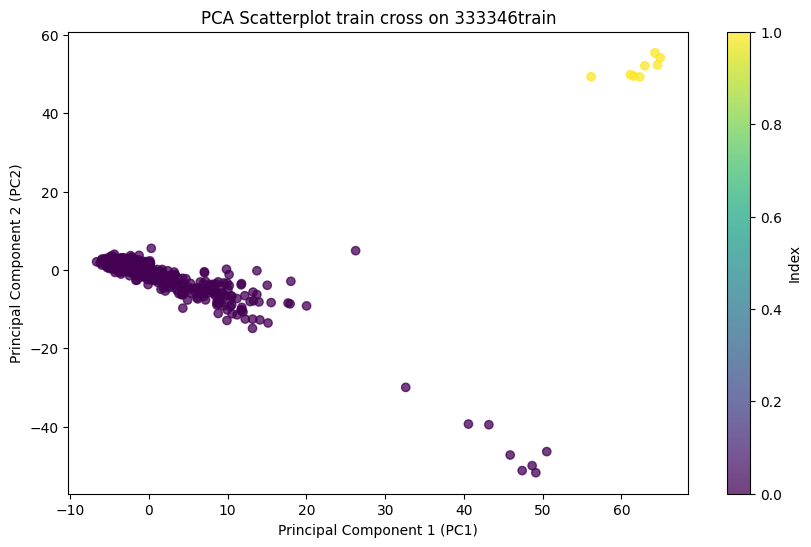

In [30]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['predicted'], cmap='viridis', alpha=0.75)
plt.title(f'PCA Scatterplot train cross on {grid_id}train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f'pca-feb-20/KNN_cross_test_on_{grid_id}_all.jpg')

# 3. Building PCA with train-test split on 333519

In [31]:
print(grid_id)

333346


In [32]:
n_components = 2
pca_train = PCA(n_components=n_components)

# Fit and transform the data
train_result = scale.fit_transform(X_train)
train_result = pca_train.fit_transform(train_result)

# Create a DataFrame with the PCA results
train_result_df = pd.DataFrame(data=train_result, columns=[f'PC{i+1}' for i in range(n_components)])

train_result_df.set_index(X_train.index)

# train_result_df['label'] = y_train
train_result_df = train_result_df.assign(label=y_train.values)


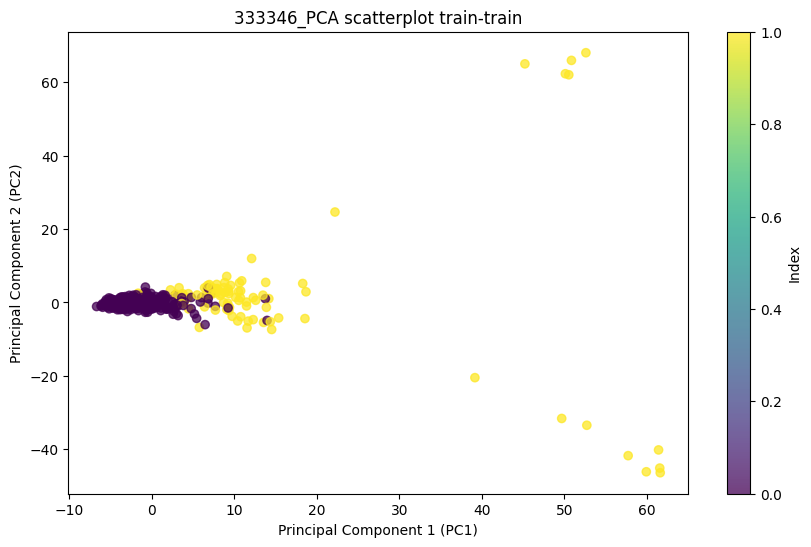

In [33]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df['PC1'], train_result_df['PC2'], c=train_result_df['label'], cmap='viridis', alpha=0.75)
plt.title(f'{grid_id}_PCA scatterplot train-train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f"{SAVE_DIR}/{grid_id}_PCA-train-train.jpg")

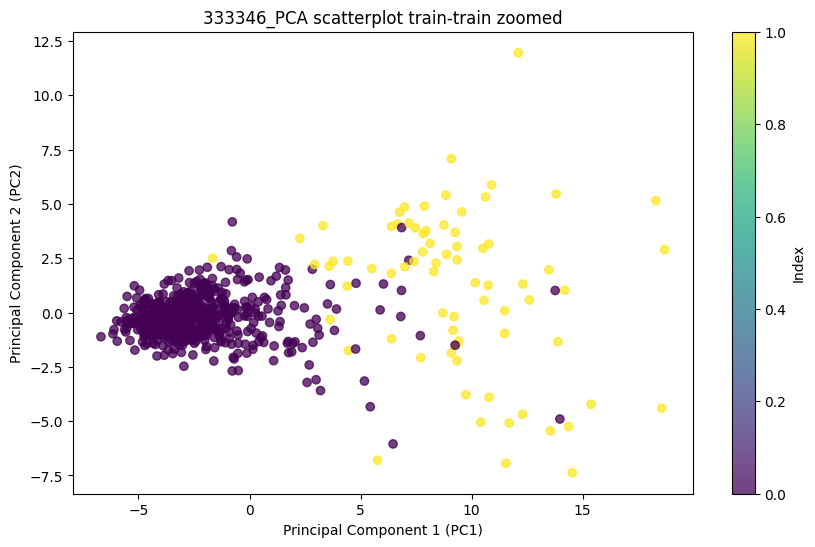

In [34]:
# Zoomed plot of pca_df with ground truth labels

train_result_df1 = train_result_df[train_result_df.PC1<20]
train_result_df1 = train_result_df1[train_result_df1.PC2<20]
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df1['PC1'], train_result_df1['PC2'], c=train_result_df1['label'], cmap='viridis', alpha=0.75)
plt.title(f'{grid_id}_PCA scatterplot train-train zoomed')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f"{SAVE_DIR}/{grid_id}_PCA-train-train zoomed.jpg")

In [35]:
test_result = scale.fit_transform(X_test)

test_result = pca_train.transform(test_result)

test_result_df = pd.DataFrame(data=test_result, columns=[f'PC{i+1}' for i in range(n_components)])

test_result_df.set_index(X_test.index)

# train_result_df['label'] = y_train
test_result_df = test_result_df.assign(label=y_test.values)


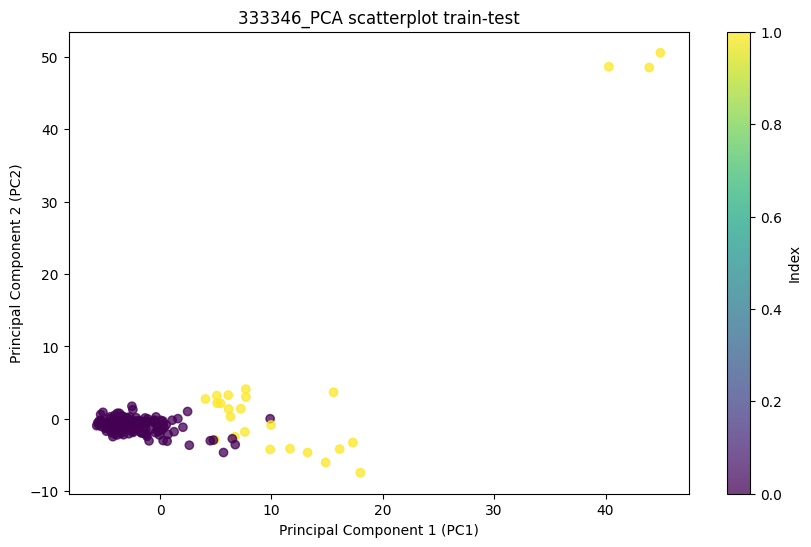

In [36]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(test_result_df['PC1'], test_result_df['PC2'], c=test_result_df['label'], cmap='viridis', alpha=0.75)
plt.title(f'{grid_id}_PCA scatterplot train-test')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.savefig(f"{SAVE_DIR}/{grid_id}_PCA-train-test zoomed.jpg")

# 3b. Saving the trained PCA model

In [37]:
pk.dump(pca_train, open(f"pca_{grid_id}.pkl","wb"))

In [38]:
# pca_reloaded = pk.load(open("pca_333519.pkl",'rb')) 
# result_new = pca_reloaded.transform(X_test) # X_new is a new data sample

In [39]:
test_result = pca_train.transform(X_test)

test_result_df = pd.DataFrame(data=test_result, columns=[f'PC{i+1}' for i in range(n_components)])

test_result_df.set_index(X_test.index)

# train_result_df['label'] = y_train
test_result_df = test_result_df.assign(label=y_test.values)

In [40]:
# # Plotting train_result_df with ground truth labels
# plt.figure(figsize=(10, 6))
# plt.scatter(test_result_df['PC1'], test_result_df['PC2'], c=test_result_df['label'], cmap='viridis', alpha=0.75)
# plt.title(f'{grid_id}_PCA scatterplot train-test')
# plt.xlabel('Principal Component 1 (PC1)')
# plt.ylabel('Principal Component 2 (PC2)')
# plt.colorbar(label='Index')


# plt.savefig(f"{SAVE_DIR}/{grid_id}_PCA-train-test.jpg")

In [41]:
# kNN train-test split
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit_predict(train_result_df[['PC1', 'PC2']])
predicted_labels = kmeans.predict(test_result_df[['PC1', 'PC2']])
test_result_df['predicted'] = predicted_labels
print(grid_id)


333346


In [42]:
test_result_df

,PC1,PC2,label,predicted
0,0.005743,0.002306,1,0
1,-0.006054,0.001245,0,0
2,0.014338,0.000004,1,0
3,-0.014028,-0.001440,0,0
4,-0.014784,-0.001642,0,0
...,...,...,...,...
168,-0.013654,-0.001094,0,0
169,-0.013353,-0.002087,0,0
170,-0.002649,0.000909,1,0
171,-0.017078,-0.002359,0,0


In [43]:
grid_id

333346

In [44]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_result_df['label'], test_result_df['predicted'])

array([[148,   0],
       [ 25,   0]])

In [45]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
recall = recall_score(test_result_df['label'], test_result_df['predicted'])
acc = accuracy_score(test_result_df['label'], test_result_df['predicted'])
precision = precision_score(test_result_df['label'], test_result_df['predicted'])
print(acc)
print(precision)
print(recall)


0.8554913294797688
0.0
0.0


# 4. Testing 333519's model on 333346

In [46]:
grid_id

333346

In [47]:
pca_reloaded = pk.load(open("pca_333519.pkl",'rb')) 
result_new = pca_reloaded.transform(X_test) # X_new is a new data sample

In [48]:

# Fit and transform the data
train_result = scale.fit_transform(X_train)
train_result = pca_reloaded.fit_transform(train_result)

# Create a DataFrame with the PCA results
train_result_df = pd.DataFrame(data=train_result, columns=[f'PC{i+1}' for i in range(2)])

train_result_df.set_index(X_train.index)

# train_result_df['label'] = y_train
train_result_df = train_result_df.assign(label=y_train.values)


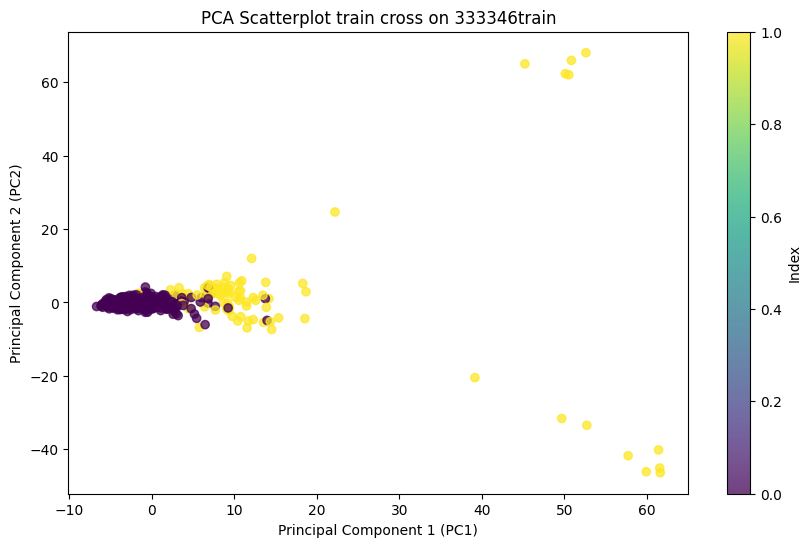

In [49]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df['PC1'], train_result_df['PC2'], c=train_result_df['label'], cmap='viridis', alpha=0.75)
plt.title(f'PCA Scatterplot train cross on {grid_id}train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f'pca-feb-20/PCA_cross_test_on_{grid_id}_all.jpg')

In [50]:
grid_id

333346

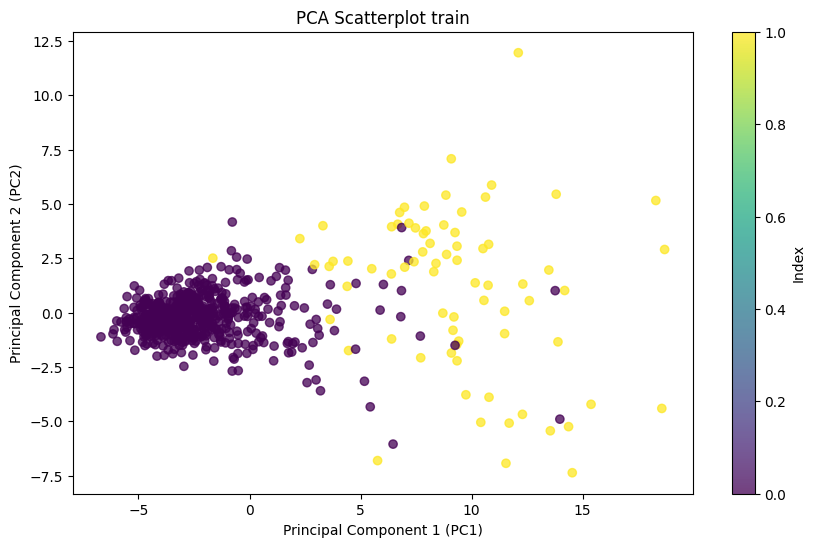

In [51]:
# Zoomed plot of pca_df with ground truth labels

train_result_df1 = train_result_df[train_result_df.PC1<20]
train_result_df1 = train_result_df1[train_result_df1.PC2<20]
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df1['PC1'], train_result_df1['PC2'], c=train_result_df1['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f'pca-feb-20/PCA_cross_test_on_{grid_id}.jpg')

In [52]:
# kNN train-test split
kmeans = KMeans(n_clusters=2, random_state=0)
predicted_labels = kmeans.fit_predict(train_result_df[['PC1', 'PC2']])
train_result_df['predicted'] = predicted_labels
print(grid_id)


333346


In [53]:
from sklearn.metrics import confusion_matrix

confusion_matrix(train_result_df['label'], train_result_df['predicted'])

array([[600,   0],
       [ 80,   8]])

In [54]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
recall = recall_score(train_result_df['label'], train_result_df['predicted'])
acc = accuracy_score(train_result_df['label'], train_result_df['predicted'])
precision = precision_score(train_result_df['label'], train_result_df['predicted'])
print(acc)
print(precision)
print(recall)


0.8837209302325582
1.0
0.09090909090909091


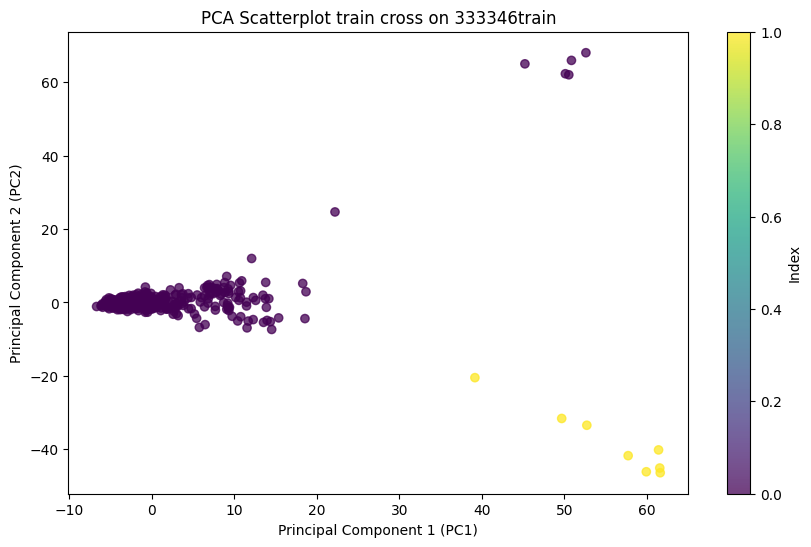

In [55]:
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df['PC1'], train_result_df['PC2'], c=train_result_df['predicted'], cmap='viridis', alpha=0.75)
plt.title(f'PCA Scatterplot train cross on {grid_id}train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f'pca-feb-20/KNN_cross_test_on_{grid_id}_all.jpg')

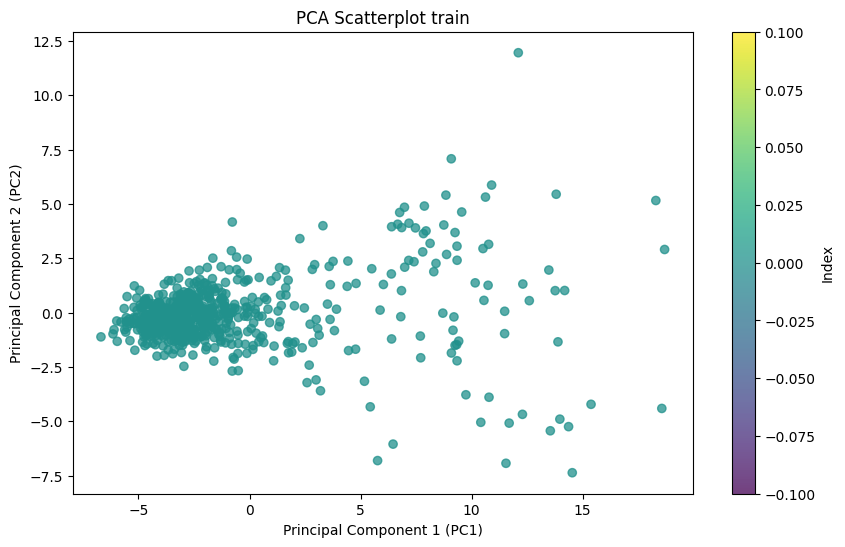

In [56]:
# Zoomed plot of pca_df with ground truth labels

train_result_df1 = train_result_df[train_result_df.PC1<20]
train_result_df1 = train_result_df1[train_result_df1.PC2<20]
# Plotting train_result_df with ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(train_result_df1['PC1'], train_result_df1['PC2'], c=train_result_df1['predicted'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot train')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')


plt.savefig(f'pca-feb-20/KNN_cross_test_on_{grid_id}.jpg')

# 5. Testing PCA